In [6]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define file path and chunk size
file_path = 'C:/Users/THINKPAD/Documents/Fraud_Detection/Fraud.csv'  # Update with your path
chunk_size = 100000

In [7]:
# Check missing values
missing_values = []
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    missing = chunk.isnull().sum()
    missing_values.append(missing)
total_missing = sum(missing_values)
print("Total Missing Values:\n", total_missing)

Total Missing Values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [8]:
# Clean chunk function
def clean_chunk(chunk):
    # Impute missing values
    chunk['amount'].fillna(chunk['amount'].median(), inplace=True)
    chunk['oldbalanceOrg'].fillna(chunk['oldbalanceOrg'].median(), inplace=True)
    chunk['newbalanceOrig'].fillna(chunk['newbalanceOrig'].median(), inplace=True)
    chunk['oldbalanceDest'].fillna(chunk['oldbalanceDest'].median(), inplace=True)
    chunk['newbalanceDest'].fillna(chunk['newbalanceDest'].median(), inplace=True)
    chunk['type'].fillna(chunk['type'].mode()[0], inplace=True)
    chunk.dropna(subset=['nameOrig', 'nameDest'], inplace=True)
    
    # Cap outliers
    numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
    for col in numeric_cols:
        Q1 = chunk[col].quantile(0.25)
        Q3 = chunk[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        chunk[col] = chunk[col].clip(lower=lower_bound, upper=upper_bound)
    
    return chunk

In [9]:
# Check multi-collinearity
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
sample_chunk = next(pd.read_csv(file_path, chunksize=chunk_size))
sample_chunk = clean_chunk(sample_chunk)
X = sample_chunk[numeric_cols]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("VIF Scores:\n", vif_data)

# Handle high VIF (>5)
high_vif = vif_data[vif_data['VIF'] > 5]['Feature'].tolist()
if high_vif:
    print("High VIF features detected:", high_vif)
    print("Creating derived features and dropping correlated ones.")

VIF Scores:
           Feature        VIF
0          amount   2.175227
1   oldbalanceOrg  10.564455
2  newbalanceOrig  10.592781
3  oldbalanceDest   6.380558
4  newbalanceDest   7.105270
High VIF features detected: ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
Creating derived features and dropping correlated ones.


In [13]:
# Preprocess data
X, y = [], []
for chunk in pd.read_csv(file_path, chunksize=chunk_size):
    chunk = clean_chunk(chunk)
    # Create derived features for high VIF
    chunk['balance_change_org'] = chunk['newbalanceOrig'] - chunk['oldbalanceOrg']
    chunk['balance_change_dest'] = chunk['newbalanceDest'] - chunk['oldbalanceDest']
    # Drop high-VIF features
    chunk = chunk.drop(['newbalanceOrig', 'newbalanceDest'], axis=1)
    # Encode categorical variable
    chunk = pd.get_dummies(chunk, columns=['type'], drop_first=True)
    # Drop identifiers
    chunk = chunk.drop(['nameOrig', 'nameDest'], axis=1)
    X_chunk = chunk.drop('isFraud', axis=1)
    y_chunk = chunk['isFraud']
    X.append(X_chunk)
    y.append(y_chunk)

X = pd.concat(X, ignore_index=True)
y = pd.concat(y, ignore_index=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.95      0.75      0.84      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.88      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC Score: 0.987885697254054


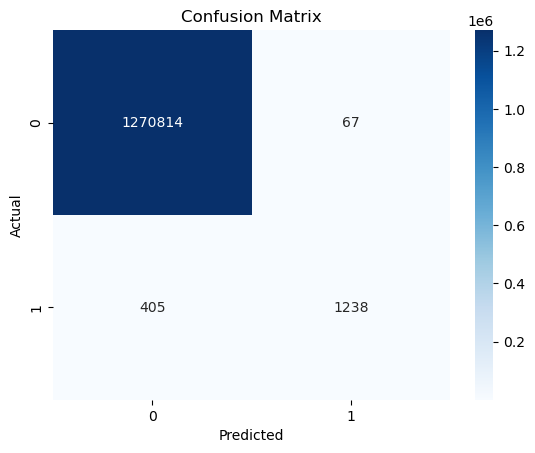

In [15]:
# Evaluate model
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba)}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance:
                 Feature  Importance
5    balance_change_org    0.351815
2         oldbalanceOrg    0.174352
1                amount    0.135210
6   balance_change_dest    0.089570
10        type_TRANSFER    0.075392
9          type_PAYMENT    0.049368
0                  step    0.048159
3        oldbalanceDest    0.041613
7         type_CASH_OUT    0.033317
8            type_DEBIT    0.000850
4        isFlaggedFraud    0.000354


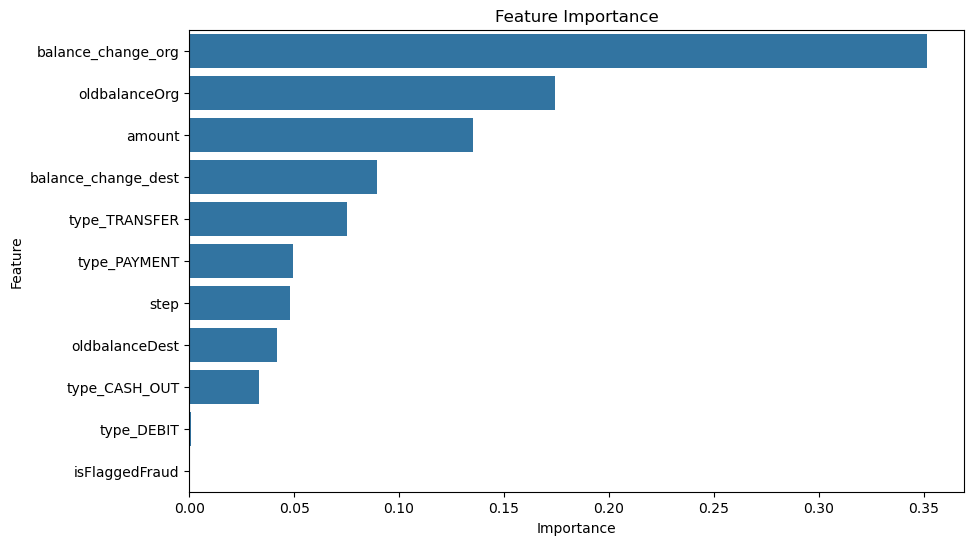

In [16]:
# Feature importance
importances = rf_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print("Feature Importance:\n", feature_importance_df.sort_values(by='Importance', ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False))
plt.title('Feature Importance')
plt.show()